## Reference Analysis

In [ ]:
import joblib
%run /home/jovyan/work/utils/pipelines.ipynb
X, y = data_tieandwin()
feature_name_list = ['X'+str(i+1) for i in range(X.shape[1])]
scal = StandardScaler()
scal.fit(X)
X = scal.transform(X)

eclf = joblib.load('ensemble_model.pkl')

feature_names = get_features_name()
originX, originy = data_tieandwin()

raw_data = change_result_from_raw2data()


In [ ]:

class InferringFeature:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        # self.x_inferring = np.arange(0, 1, 0.001)
        self.scaled_X = scal.fit_transform(X)
        # self.scaled_X = preprocessor.fit_transform(X)

    def get_x_coordinate(self, feature_index=1, x_type='continous'):
        if self.x_coordinate_next != '':
            return self.x_coordinate_next 
        if x_type=='continous':
            feature = self.X[:, feature_index]
            return np.arange(feature.min(), feature.max(), .01)
        else:
            feature = self.X[:, feature_index]
            return np.sort(np.unique(originX[:, feature_index]))
        
    x_coordinate_next = ''

    def infer(
        self, model, need_plot = True, predict_func = 'predict_proba', 
        feature_index = 1, result_index=1,x_type = 'continous',
        plot_args = {}, need_std = False
    ):
        specificFeature = self.X[:, feature_index].reshape(-1,1)

        y_inferring = []
        y_inferring_std = []
        x_inferring = self.get_x_coordinate(feature_index, x_type)
        feature_mean = originX[:, feature_index].mean()
        feature_std = originX[:, feature_index].std()
        for v in x_inferring:
            v_scaled = v
            # if x_type == 'continous':
            v_scaled = (v - feature_mean) / feature_std # standard scale for each v
            modifiedX = self.scaled_X.copy()
            modifiedX[:, feature_index] = v_scaled # modify home attendance
            modified = eval('model.{}(modifiedX)'.format(predict_func))
            modified_mean = modified[:, result_index].mean() if len(modified.shape) >1 else modified.mean()
            modified_std = modified[:, result_index].std() if len(modified.shape) >1 else modified.std()
            y_inferring.append(modified_mean)
            y_inferring_std.append(modified_std)
        if need_plot:
            self.plot(y_inferring, feature_index=feature_index,result_index=result_index, x_type=x_type, **plot_args)
        self.x_coordinate_next=''

        if need_std:
            return y_inferring, y_inferring_std
        else:
            return y_inferring
    
    def plot(self, y, title=None, result_index=1, feature_index=1, x_type='continous', xlabel='Home Attendance Percentage'):
        x_inferring = self.get_x_coordinate(feature_index, x_type)
        plt.plot(x_inferring, y, label='modified')
        if title:
            plt.title(title)
        plt.ylabel('Mean of predicting result P(y = {})'.format(result_index))
        plt.xlabel(xlabel)
        # plt.legend()
        sns.despine()
        self.x_coordinate_next=''
        return plt

def save_inferred_results(x, y, feature_index, name='', std=False):
    # date = datetime.date.today().strftime('%Y/%m/%d')
    data = pd.DataFrame(np.c_[x, y], columns=[feature_names[feature_index], 'mean'])
    if std:
        data['std'] = std
    data.to_csv('inferred_results_0424_presentation/{}.csv'.format(name if name != '' else 'feature'+str(feature_index+1)), index=False)

    
def inferring(condition, name='', model=eclf, i=1, need_plot=False, origin_x=originX, origin_y=originy, need_save=True, savedTemplate='playground-{}-attendance'):
    originX2 = origin_x[condition]
    originy2 = origin_y[condition]
    
    infer_obj = InferringFeature(originX2, originy2)
    infer_y = infer_obj.infer(model, False, feature_index=1, x_type='continous')
    infer_x = infer_obj.get_x_coordinate(feature_index=1, x_type='continous')

    if need_save:
        save_inferred_results(infer_x, infer_y, i, savedTemplate.format(name))

    if need_plot == True:
        infer_obj.plot(infer_y, xlabel='Home Attendance Percentage')
        plt.ylim(.6,.8)

def inferring2(condition, name='', model=eclf, i=1, need_plot=False, need_save=True, origin_x=originX, origin_y=originy, savedTemplate='playground-{}-attendance'):
    originX2 = origin_x[condition]
    originy2 = origin_y[condition]
    
    infer_obj = InferringFeature(originX2, originy2)
    infer_obj.x_coordinate_next = np.arange(0, origin_x[:, 1].max(), .01)
    infer_y = infer_obj.infer(model, False, feature_index=1, x_type='continous')
    infer_x = np.arange(0, origin_x[:, 1].max(), .01)

    if need_save:
        save_inferred_results(infer_x, infer_y, i, savedTemplate.format(name))

    if need_plot == True:
        infer_obj.plot(infer_y, xlabel='Home Attendance Percentage')
        plt.ylim(.6,.8)

In [ ]:
# for i, team_data in raw_datapby('HomeTeam'):
#     inferring()

for team_name in raw_data['HomeTeam'].unique():
    condition = raw_data['HomeTeam'] == team_name
    inferring2(condition, name=team_name, savedTemplate='team-{}')


In [ ]:
max_results = []
cc = raw_data.groupby('HomeTeam').count()['X1'].sort_values() < 5
cc_names = cc[cc == True].index
for team_name in raw_data['HomeTeam'].unique():
    if team_name in cc_names:
        continue
    dd = pd.read_csv('inferred_results_0424_presentation/team-{}.csv'.format(team_name))
    # sns.lineplot(x=cols[0], y=cols[1], data=feature2)
    idx_max = dd.iloc[:, 1].idxmax()
    max_results.append([dd.iloc[idx_max, 0], dd.iloc[idx_max, 1], team_name])
    # plt.plot('Home attendance percentage', 'mean', data=dd, alpha=.5)
max_results = pd.DataFrame(max_results, columns=['x', 'y', 'Team'])
print(max_results[max_results['y']<.7])
max_results = max_results[max_results['y']>.7]
sns.scatterplot(max_results['x']*100, 'y', data=max_results, hue='Team', legend=False)
plt.xlim(0,100)
plt.xlabel('Home attendance percentage')
plt.ylabel('Unbeaten rate')
plt.title('Max predicted unbeaten rate for each stadium')
sns.despine()


In [ ]:
cc = raw_data.groupby('HomeTeam').count()['X1'].sort_values() < 5
cc_names = cc[cc == True].index
print(cc_names)
for team_name in raw_data['HomeTeam'].unique():

    if team_name in cc_names:
        continue
    dd = pd.read_csv('inferred_results_0424_presentation/team-{}.csv'.format(team_name))
    # sns.scatterplot(x=dd.iloc[idx_max, 0], y=dd.iloc[idx_max, 1])
    sns.lineplot(x=dd['Home attendance percentage']*100, y='mean', data=dd)
    # idx_max = dd.iloc[:, 1].idxmax()
    # max_results.append([dd.iloc[idx_max, 0], dd.iloc[idx_max, 1], team_name])
plt.ylabel('Unbeaten rate')
plt.title('Predicted unbeaten rate for each stadium')
plt.xlim(0,100)
sns.despine()

In [ ]:
name_list = raw_data['HomeTeam'].unique()

In [ ]:
team_name = 'norwich-city'

In [ ]:
dd = pd.read_csv('inferred_results_0424_presentation/team-{}.csv'.format(team_name))


0.8300000000000001 0.7111528234331924


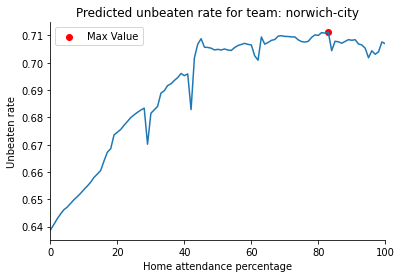

In [ ]:
sns.lineplot(x=dd['Home attendance percentage']*100, y='mean', data=dd)
idx_max = dd.iloc[:, 1].idxmax()
plt.scatter(x=dd.iloc[idx_max, 0]*100, y=dd.iloc[idx_max, 1], color='red', label='Max Value')
plt.legend()
plt.ylabel('Unbeaten rate')
plt.title('Predicted unbeaten rate for team: {}'.format(team_name))
plt.xlim(0,100)
sns.despine()

In [ ]:
# row_test_data[swindon-town]
# raw_data.query('HomeTeam == "brentford-fc"')
cc = raw_data.groupby('HomeTeam').count()['X1'].sort_values() < 10
# cc[cc == True].index
cc

HomeTeam
brentford-fc                True
swindon-town                True
barnsley-fc                 True
oldham-athletic             True
blackpool-fc                True
bradford-city               True
cardiff-city                True
huddersfield-town           True
queens-park-rangers         True
nottingham-forest          False
ipswich-town               False
reading-fc                 False
afc-bournemouth            False
brighton-hove-albion       False
hull-city                  False
sheffield-wednesday        False
sheffield-united           False
portsmouth-fc              False
watford-fc                 False
burnley-fc                 False
charlton-athletic          False
swansea-city               False
wolverhampton-wanderers    False
birmingham-city            False
derby-county               False
wimbledon-fc               False
norwich-city               False
wigan-athletic             False
stoke-city                 False
coventry-city              False
c

### Infer all features

In [ ]:
eclf.predict(X)

array([1., 1., 1., ..., 1., 1., 1.])

In [ ]:
raw_data.shape

(9381, 27)

In [ ]:
raw_data.tail()

,HomeTeam,AwayTeam,Date,Season,X1,X2,X3,X4,X5,X6,...,X14,X15,X16,X17,X18,X19,X20,X21,X22,Y
9376,middlesbrough-fc,manchester-united,2017/03/19,2016-2017,35100.0,0.931311,17.0,6.0,20,5,...,4,2,2,5.0,2.0,5.0,2.0,5.0,27.0,0.0
9377,everton-fc,swansea-city,2011/12/21,2011-2012,40157.0,0.796972,14.0,12.0,7,20,...,1,2,1,3.0,9.0,3.0,9.0,0.0,17.0,1.0
9378,blackburn-rovers,bolton-wanderers,1996/02/03,1995-1996,31149.0,0.976564,7.0,20.0,1,20,...,1,1,1,12.0,11.0,12.0,11.0,1.0,25.0,1.0
9379,southampton-fc,west-bromwich-albion,2004/11/06,2004-2005,32689.0,0.950075,18.0,17.0,12,20,...,2,4,1,5.0,12.0,5.0,12.0,5.0,12.0,1.0
9380,newcastle-united,aston-villa,1994/04/27,1993-1994,52409.0,0.614723,3.0,10.0,20,2,...,1,2,1,15.0,7.0,15.0,7.0,4.0,40.0,1.0


In [ ]:
feature_name_list, feature_names

(['X1',
  'X2',
  'X3',
  'X4',
  'X5',
  'X6',
  'X7',
  'X8',
  'X9',
  'X10',
  'X11',
  'X12',
  'X13',
  'X14',
  'X15',
  'X16',
  'X17',
  'X18',
  'X19',
  'X20',
  'X21',
  'X22'],
 array(['Capacity of the stadium', 'Home attendance percentage',
        'Current ranking of home teams', 'Current ranking of away teams',
        'Ranking of home teams in the last season',
        'Ranking of away teams in the last season',
        'Result of the 1st match in the last 5 Premier League matches of home teams',
        'Result of the 2nd match in the last 5 Premier League matches of home teams',
        'Result of the 3rd match in the last 5 Premier League matches of home teams',
        'Result of the 4th match in the last 5 Premier League matches of home teams',
        'Result of the 5th match in the last 5 Premier League matches of home teams',
        'Result of the 1st match in the last 5 Premier League matches of away teams',
        'Result of the 2nd match in the last 5 Prem

In [ ]:
import datetime
date = datetime.date.today().strftime('%Y/%m/%d')

In [ ]:
# date = datetime.date.today().strftime('%Y%m%d')
infer_obj = InferringFeature(originX, originy)
for i, name in enumerate(feature_names):
    # if i == 0:
    #     continue
    # if i <2:
    #     continue
    x_type=''
    if i == 0:
        capacity = originX[:, 0]
        infer_x = np.hstack([np.arange(capacity.min(), capacity.max(), 1000), capacity.max()])
        infer_obj.x_coordinate_next = infer_x
        infer_y, infer_y_std = infer_obj.infer(eclf, False, x_type='continous', feature_index=i, need_std=True)
    else:
        if i ==1:
            x_type = 'continous'
        else:
            x_type = 'interval'
        infer_y, infer_y_std = infer_obj.infer(eclf, False, x_type=x_type, feature_index=i, need_std=True)
        infer_x = infer_obj.get_x_coordinate(feature_index=i, x_type=x_type)
    # print(infer_y_std)
    save_inferred_results(infer_x, infer_y, i, 'all-feature{}'.format(i+1), std=infer_y_std)

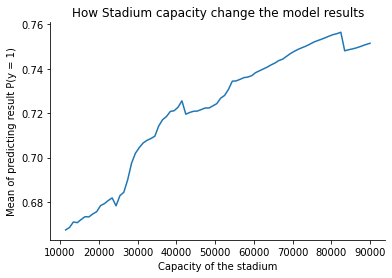

In [ ]:
feature2 = pd.read_csv('inferred_results_0424_presentation/all-feature1.csv')
cols = feature2.columns
# plt.plot(x=columns[0], y=cols)
# plt.fill_between(feature2[cols[0]], feature2[cols[1]]+feature2['std'], feature2[cols[1]]-feature2['std'], alpha=.3)
sns.lineplot(x=cols[0], y=cols[1], data=feature2)
# plt.ylim(.4,.8)
plt.ylabel('Mean of predicting result P(y = 1)')
# plt.xlim(0,0.99)
plt.title('How Stadium capacity change the model results')
sns.despine()

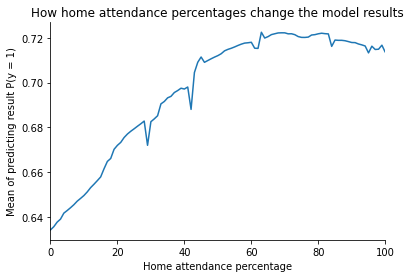

In [ ]:
feature2 = pd.read_csv('inferred_results_0424_presentation/all-feature2.csv')
cols = feature2.columns
# plt.plot(x=columns[0], y=cols)
# plt.fill_between(feature2[cols[0]], feature2[cols[1]]+feature2['std'], feature2[cols[1]]-feature2['std'], alpha=.3)
# datafea
feature2[cols[0]] = feature2[cols[0]]*100
sns.lineplot(x=cols[0], y=cols[1], data=feature2)
# sns.scatterplot(x=cols[0], y=cols[1], data=feature2)
# plt.ylim(.4,.9)
plt.ylabel('Mean of predicting result P(y = 1)')
# plt.xlim(0,0.99)
plt.xlim(0,100)
plt.title('How home attendance percentages change the model results')
sns.despine()

In [ ]:
feature2.iloc[:, 1].max() - feature2.iloc[:, 1].min()

0.08829756835127589

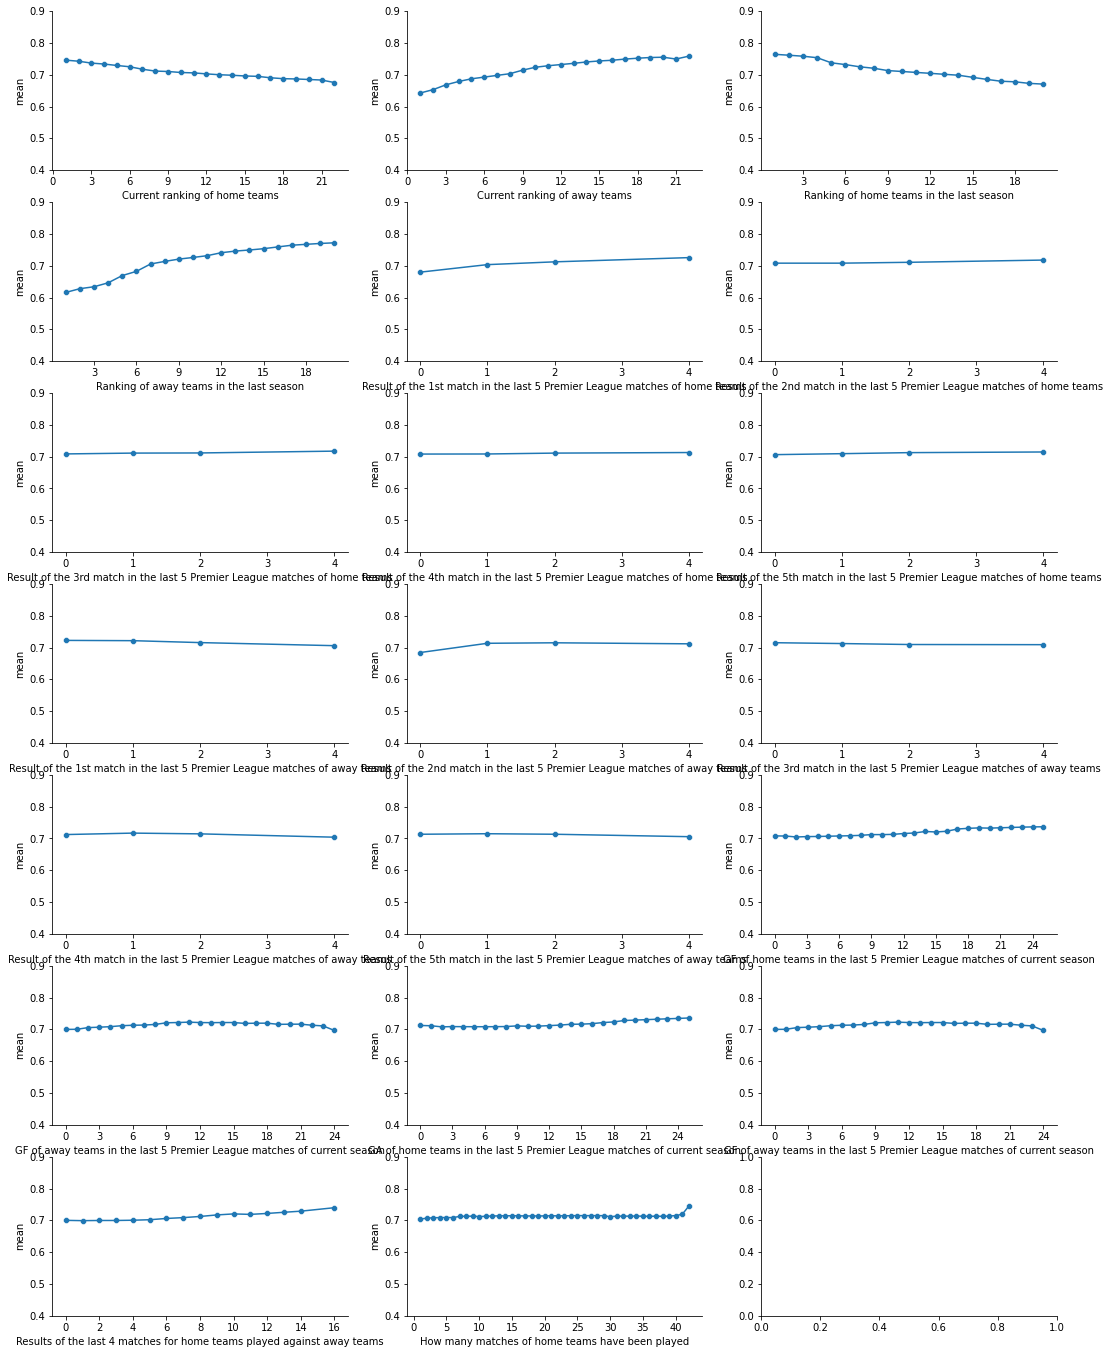

In [ ]:
from matplotlib.ticker import MaxNLocator

number_in_row = 3
fig, axes = plt.subplots(7, number_in_row, figsize=(18,24))
draw_names = feature_names[2:]
for i, name in enumerate(draw_names):
    # if i < 2:
    #     continue
    current_row = (i // number_in_row)
    current_i = (i % number_in_row) 
    # print(current_row, current_i)

    file_index = feature_names.tolist().index(name)
    # print(file_index)
    feature_data = pd.read_csv('inferred_results_0424_presentation/all-feature{}.csv'.format(file_index+1))
    cols = feature_data.columns

    ax = axes[current_row, current_i]

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    # ax.fill_between(feature_data[cols[0]], feature_data[cols[1]]+feature_data['std'], feature_data[cols[1]]-feature_data['std'], alpha=.3)
    sns.lineplot(ax=ax, x=cols[0], y=cols[1], data=feature_data)
    sns.scatterplot(ax=ax, x=cols[0], y=cols[1], data=feature_data)
    # ax.set_ylim(.6,.5)
    ax.set_ylim(.4,.9)
    sns.despine()

### Analysis each club

In [ ]:
team_play_times = raw_data.groupby('HomeTeam').count()['X1'].sort_values( ascending=False)


f1s, accuracys, team_names =[], [], []
for home_team, data in  raw_data.groupby('HomeTeam'):
    if len(data) < 20:
        continue
    x = scal.transform(data.iloc[:, 4:-1].to_numpy())
    y = data.iloc[:, -1]
    y_pred = eclf.predict(x)
    f1s.append(f1_score(y, y_pred))
    accuracys.append(accuracy_score(y, y_pred))
    team_names.append(home_team)

[Text(0, 0.5, 'Played numbers')]

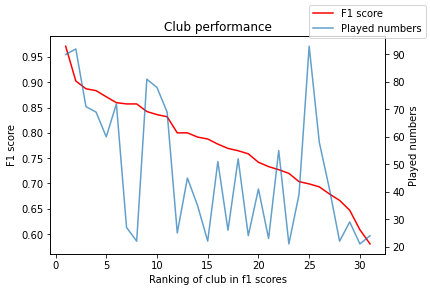

In [ ]:
evaluates = pd.DataFrame(np.c_[f1s, accuracys], index=team_names, columns=[ 'F1 score','Accuracy'])
# sns.lineplot(y = 'F1_score', data=evaluates)

evaluates = pd.merge(evaluates, team_play_times, left_index=True, right_index=True)
evaluates.rename({'X1':'numbers'}, axis=1, inplace=True)
# evaluates.sort_values(by='numbers', ascending=False, inplace=True)
evaluates.sort_values(by='F1 score', ascending=False, inplace=True)

evaluates.reset_index(inplace=True)
sorted_numbers = (evaluates['numbers'] - evaluates['numbers'].min()) / (evaluates['numbers'].max() - evaluates['numbers'].min())
evaluates['numbers_normalised'] = sorted_numbers
evaluates.rename({'index':'Club Name', 'numbers':'Played numbers'}, axis=1, inplace=True)

evaluates['rank'] = rangking_indices = np.array(evaluates.index)+1

# ax = sorted_numbers(label='Played numbers')


ax = evaluates.plot(x='rank', y = 'F1 score', legend=False, color='r')
ax2 = ax.twinx()
evaluates.plot(x='rank', y = 'Played numbers', ax=ax2, legend=False, alpha=.7)
ax.figure.legend()

ax.set(xlabel='Ranking of club in f1 scores', ylabel='F1 score', title='Club performance')
ax2.set(ylabel='Played numbers')

In [ ]:
rangking_indices = np.array(evaluates.index)+1
rangking_indices

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [ ]:
showing = evaluates.copy()
showing['F1 score'] = np.round(showing['F1 score'], 3)
showing = showing[showing['Played numbers'] > 20]
showing[['Club Name', 'F1 score', 'Played numbers']].head(21)

,Club Name,F1 score,Played numbers
0,manchester-united,0.971,90
1,liverpool-fc,0.902,92
2,arsenal-fc,0.887,71
3,chelsea-fc,0.883,69
4,manchester-city,0.871,60
5,everton-fc,0.860,72
6,coventry-city,0.857,27
7,swansea-city,0.857,22
8,newcastle-united,0.842,81
9,aston-villa,0.836,78


### Split by playground

In [ ]:
condition = originX[:, 0] < 30000
inferring2(condition, name="lt30000", origin_x=originX, origin_y=originy)

In [ ]:
condition3 = originX[:, 0] > 50000
inferring2(condition3, name="gt50000", origin_x=originX, origin_y=originy)

In [ ]:
condition2 = (originX[:, 0] >= 30000) & (originX[:, 0] < 50000)
inferring2(condition2, name="lt50000", origin_x=originX, origin_y=originy)

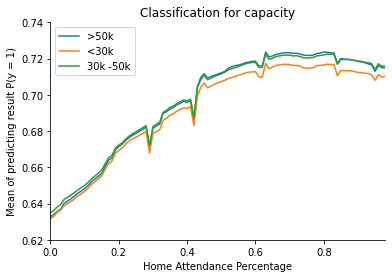

In [ ]:
d2 = pd.read_csv('/work/inferred_results_0424_presentation/playground-gt50000-attendance.csv')
cols1 = d2.columns
sns.lineplot(x=cols1[0], y=cols1[1], data=d2, label='>50k')

d3 = pd.read_csv('/work/inferred_results_0424_presentation/playground-lt30000-attendance.csv')
cols1 = d3.columns
sns.lineplot(x=cols1[0], y=cols1[1], data=d3, label='<30k')
d3 = pd.read_csv('/work/inferred_results_0424_presentation/playground-lt50000-attendance.csv')
cols1 = d3.columns
sns.lineplot(x=cols1[0], y=cols1[1], data=d3, label='30k -50k')
plt.ylim(.62,.74)
plt.xlabel('Home Attendance Percentage')
plt.ylabel('Mean of predicting result P(y = 1)')
plt.xlim(0,0.98)
plt.title('Classification for capacity')
sns.despine()
plt.legend()

### Strengthen

In [ ]:
condition4 = originX[:, 4]< 5
inferring2(condition4, 'topteam', origin_x=originX, origin_y=originy)
condition5 = originX[:, 4]> 15
inferring2(condition5, 'smallteam', origin_x=originX, origin_y=originy)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # Remove the CWD from sys.path while we load stuff.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # Remove the CWD from sys.path while we load stuff.


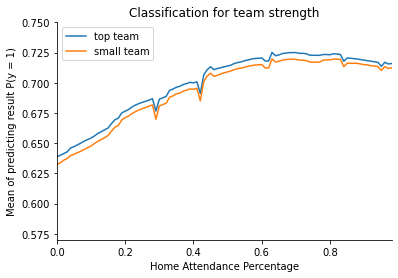

In [ ]:
d4 = pd.read_csv('/work/inferred_results_0424_presentation/playground-topteam-attendance.csv')
cols1 = d4.columns
sns.lineplot(x=cols1[0], y=cols1[1], data=d4, label='top team')

d5 = pd.read_csv('/work/inferred_results_0424_presentation/playground-smallteam-attendance.csv')
cols2 = d5.columns
sns.lineplot(x=cols2[0], y=cols2[1], data=d5, label='small team')

plt.ylim(.57,.75)
plt.xlabel('Home Attendance Percentage')
plt.ylabel('Mean of predicting result P(y = 1)')
plt.xlim(0,0.98)
plt.title('Classification for team strength')
sns.despine()

In [ ]:
dd = pd.to_datetime(raw_data['Date'])
cc = dd > np.datetime64('2017-01-01')
inferring2(cc, 'last5y')

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # Remove the CWD from sys.path while we load stuff.


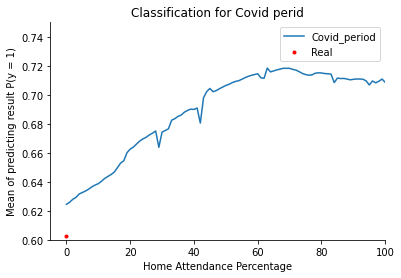

In [ ]:
d6 = pd.read_csv('/work/inferred_results_0424_presentation/playground-covid_period-attendance.csv')
cols3 = d6.columns
sns.lineplot(x=d6[cols3[0]]*100, y=cols3[1], data=d6, label='Covid_period')

# plt.ylim(.57,.75)
plt.plot(0, raw_data[raw_data['X2'] == 0]['Y'].mean(), 'r.', label='Real')
plt.xlabel('Home Attendance Percentage')
plt.ylabel('Mean of predicting result P(y = 1)')
plt.xlim(-5,100)
plt.ylim(.6, .75)
plt.title('Classification for Covid perid')
plt.legend()
sns.despine()

In [ ]:
condition = (raw_data['X2'] == 0) & (raw_data['Y'] == 0)
inferring(condition, 'covid_periody0', )

originX2 = originX[condition]
originy2 = originyition]

infer_obj = InferringFeature(originX2, originy2)
infer_obj.x_coordinate_next = np.arange(0, originX[:, 1].max(), .01)
infer_y = infer_obj.infer(eclf, False, feature_index=1, x_type='continous')
infer_x = np.arange(0, originX[:, 1].max(), .01)

capacity = originX2[:, 0]
save_inferred_results(infer_x, infer_y, 1, 'playground-{}-attendance'.format('covid_periody0'))


In [ ]:
d6 = pd.read_csv('/work/inferred_results_0424_presentation/playground-covid_periody0-attendance.csv')
cols3 = d6.columns
sns.lineplot(x=cols3[0], y=cols3[1], data=d6, label='Covid_period')

# plt.ylim(.57,.75)
plt.plot(0, raw_data[raw_data['X2'] == 0]['Y'].mean(), 'r.', label='Real')
plt.xlabel('Home Attendance Percentage')
plt.ylabel('Mean of predicting result P(y = 1)')
plt.xlim(-.05, 0.99)
plt.ylim(.6, .75)
plt.title('Classification for Covid perid')
plt.legend()
sns.despine()

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance
  
# create permutation importance object using model
perm4 = PermutationImportance(eclf, random_state=2, n_iter=20, scoring='f1').fit(X, y)


# display weights using PermutationImportance object
eli5.show_weights(perm4, feature_names = feature_name_list)

Weight,Feature
0.1043 ± 0.0025,X6
0.0883 ± 0.0017,X4
0.0833 ± 0.0019,X5
0.0795 ± 0.0022,X3
0.0769 ± 0.0017,X1
0.0730 ± 0.0014,X21
0.0716 ± 0.0014,X2
0.0706 ± 0.0014,X22
0.0660 ± 0.0022,X18
0.0634 ± 0.0018,X19


Text(0.5, 1.0, 'Permutation importance')

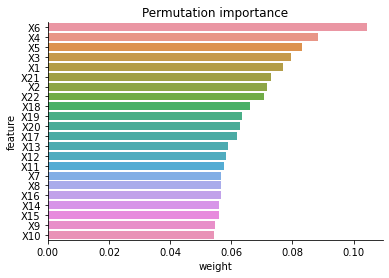

In [ ]:
pi_df4 = eli5.explain_weights_df(perm4, feature_names = feature_name_list)
pi_df4.to_csv('permutation_importance_f1.csv', index=False)
sns.barplot(x='weight', y='feature', data=pi_df4)
sns.despine()
plt.title('Permutation importance')

In [ ]:
futures = pd.read_csv('/home/jovyan/work/demostration/datasets/future.csv')
futures_X, futures_y = split_Xy(futures)
futures_X = scal.fit_transform(futures_X)
# eclf.predict()
# futures_X.shape
f1_score(futures_y, eclf.predict(futures_X))

0.8

In [ ]:
feature_names

array(['Capacity of the stadium', 'Home attendance percentage',
       'Current ranking of home teams', 'Current ranking of away teams',
       'Ranking of home teams in the last season',
       'Ranking of away teams in the last season',
       'Result of the 1st match in the last 5 Premier League matches of home teams',
       'Result of the 2nd match in the last 5 Premier League matches of home teams',
       'Result of the 3rd match in the last 5 Premier League matches of home teams',
       'Result of the 4th match in the last 5 Premier League matches of home teams',
       'Result of the 5th match in the last 5 Premier League matches of home teams',
       'Result of the 1st match in the last 5 Premier League matches of away teams',
       'Result of the 2nd match in the last 5 Premier League matches of away teams',
       'Result of the 3rd match in the last 5 Premier League matches of away teams',
       'Result of the 4th match in the last 5 Premier League matches of away team

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b150ef30-52fe-41e2-b3cd-643278d2147a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>